In [ ]:
## lrasmy@Zhilab last revised August 1 2021 ##
##############################################

In [1]:
### Mount your google drive ###
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Required packages

Make sure that you are using a GPU Runtime


In [2]:
### install required packages
! pip install lifelines --user
! pip install pip install 'ray[default]'
! pip install 'ray[tune]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import time
from tqdm import tqdm

## ML and Stats
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
import sklearn.linear_model  as lm
import lifelines
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import export_graphviz
from termcolor import colored

## Deep Learning Pytorch
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
#if use_cuda: torch.cuda.set_device(7)




#### Please Note: if any error message displayed or you installed fresh packages, please make sure you run the following pytorch_ehr import cell **twice**

---



---



In [4]:
from importlib import reload

### import pytorch ehr files
try:
  import sys
  sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
  import pytorch_ehr
  import pytorch_ehr.models as model
  from pytorch_ehr.EHRDataloader import EHRdataloader
  from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
  import pytorch_ehr.utils_final as ut
  from pytorch_ehr.EHREmb import EHREmbeddings
except:
  exit()
  print('Notebook restarted after package installation')

In [5]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
import pytorch_ehr
import pytorch_ehr.models as model
from pytorch_ehr.EHRDataloader import EHRdataloader
from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
import pytorch_ehr.utils_final as ut
from pytorch_ehr.EHREmb import EHREmbeddings

### load preprocessed data

In [6]:
input_dir='/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data/'
data_prefix='/dhf_easy_dmd_v1'
output_dir = '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/Model_output/'
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [7]:
### Load the preprocessed data

train_sl= pickle.load(open(input_dir+data_prefix+'.combined.train', 'rb'),encoding='bytes')
test_sl= pickle.load(open(input_dir+data_prefix+'.combined.test', 'rb'), encoding='bytes')
valid_sl= pickle.load(open(input_dir+data_prefix+'.combined.valid', 'rb'), encoding='bytes')
# types dictionary
types_d=pickle.load(open(input_dir+data_prefix+'.types', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))
input_size_l=[max(types_d_rev.keys())+1]
print (len(train_sl),len(valid_sl),len(test_sl))
print(input_size_l)

8485 1211 2423
[432]


In [8]:
test_sl2= pickle.load(open(input_dir+'/dhf_hard_dmd_v1'+'.combined.test', 'rb'), encoding='bytes')
print (len(test_sl2))

2343


In [9]:
def load_mbs_var_list(sets_list,packpadmode,task,bs=128,half=True):
    if task: multiLbl=True
    mb_lists=[]
    for dset in sets_list:
        print (' creating the list of minibatches')
        dataset = EHRDataset(dset,sort= True, model='RNN')
        data_mbs = list(tqdm(EHRdataloader(dataset, batch_size = bs, packPadMode = packpadmode,multilbl=multiLbl)))
        mb_lists.append(data_mbs)
    return mb_lists


In [10]:
reload(ut)

<module 'pytorch_ehr.utils_final' from '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/pytorch_ehr/utils_final.py'>

In [11]:
[train_mbs,valid_mbs,test_mbs]=load_mbs_var_list([train_sl,valid_sl,test_sl],packpadmode=True,task='HF',bs=256)

 creating the list of minibatches
multilabel data processing


100%|██████████| 34/34 [01:21<00:00,  2.39s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


### Model Training

#### Binary Classification

In [12]:
#### Binary classification Model
ehr_model=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=32, n_layers=1,cell_type='GRU',bii=True ,time=True, packPadMode=True, surv=False, cls_dim=1)
if use_cuda:ehr_model.cuda()
train_auc_allep,valid_auc_allep,test_auc_allep,RNN_f_label,RNN_f_score=ut.run_dl_model(ehr_model,train_mbs,valid_mbs,[test_mbs],output_dir+'ICHI_2023_t1.pth',output_dir+'ICHI_2023_t1.st',wmodel='RNN',packpadmode=True,task='HF',opt='Adamax', lr=0.1)


weights :  None
Epoch:  0  Train_auc : 0.8080124395062358  , Valid_auc :  0.7938448956472987  Avg Loss:  0.7007220476865769  , Train Time : 0m 1s
 & Test_auc s :  [0.8119949621726396]
Eval Time : 0m 0s

 Confusion matrix yellow
[[981 536]
 [170 736]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.85      0.65      0.74      1517
         1.0       0.58      0.81      0.68       906

    accuracy                           0.71      2423
   macro avg       0.72      0.73      0.71      2423
weighted avg       0.75      0.71      0.71      2423

Epoch:  1  Train_auc : 0.8792274201874308  , Valid_auc :  0.8537675053028857  Avg Loss:  0.5118171175320942  , Train Time : 0m 0s
 & Test_auc s :  [0.8723350227953686]
Eval Time : 0m 0s

 Confusion matrix yellow
[[1290  227]
 [ 177  729]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.88      0.85      0.86      1517
         1.0       0.76 

#### Survival

In [13]:
###Survival Model
ehr_model_s=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=64, n_layers=1,cell_type='GRU',bii=True ,time=True, packPadMode=True, surv=True)
if use_cuda:ehr_model_s.cuda()

train_auc_allep_S,valid_auc_allep_S,test_auc_allep_S,RNN_f_label_S,RNN_f_score_S=ut.run_dl_model_surv(ehr_model_s,train_mbs,valid_mbs,[test_mbs],output_dir+'ICHI_2023_s1.pth',output_dir+'ICHI_2023_s1.st',wmodel='RNN',packpadmode=True,task='HF_surv',patience=5)


Epoch:  0  Train_cindex : 0.6496389711084996  , Valid_cindex :  0.6067930075833661  Avg Loss:  4.142338657379151  , Train Time : 0m 0s
 & Test_auc s :  [0.6389186047111106]
Eval Time : 0m 0s
Epoch:  1  Train_cindex : 0.6688636064294998  , Valid_cindex :  0.6259382171569412  Avg Loss:  4.006428933143615  , Train Time : 0m 0s
 & Test_auc s :  [0.6582820789103301]
Eval Time : 0m 0s
Epoch:  2  Train_cindex : 0.7085627456165517  , Valid_cindex :  0.6728211771441325  Avg Loss:  3.9297331730524694  , Train Time : 0m 0s
 & Test_auc s :  [0.6949706651131378]
Eval Time : 0m 0s
Epoch:  3  Train_cindex : 0.6935232274512647  , Valid_cindex :  0.6490085343192195  Avg Loss:  3.870254079500834  , Train Time : 0m 0s
Epoch:  4  Train_cindex : 0.6984984016099275  , Valid_cindex :  0.6501972257397785  Avg Loss:  3.8296138445536294  , Train Time : 0m 0s
Epoch:  5  Train_cindex : 0.724499577812651  , Valid_cindex :  0.6736217244273661  Avg Loss:  3.8457909266153973  , Train Time : 0m 0s
 & Test_auc s :  [0.

### Hyperparameter Tunninig

5 years ago, Bayesian optimization was the SOTA of hyperparemeters search, an example resource is Botorch

Nowadays there many new packages for hyperparameter search exist, some popular examples include RayTune and Optuna

Actually you can even combine both where you can get the benefit of the best computational resources utilization from ray tune and the optuna search algorithm.
More examples are on:

 Pytorch Raytune Tutorial: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html?highlight=transformer

Using Optuna algorithm in Raytune:
https://docs.ray.io/en/master/tune/api_docs/suggestion.html#tune-optuna

Optuna code examples (select pytorch): https://optuna.org/#code_examples

Optuna tutorial on multi-objective optimization: https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py


####### here I'll only show a very shallow hand written example on the main concept for the sake of time


In [ ]:
def run_dl_model_hps(config, input_size_1=[27362],epochs=100, task='mort', w_model='RNN', packpadmode=True, patience=10):
    ### for raytune, you need to limit your input to the config or use tune.with_parameters
    ### for optuna, your input will be the trial
    ### Further examples can be found above

    sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    from pytorch_ehr import models as model
    from pytorch_ehr import utils_final as ut

    l2 = config['l2']
    lr = config['lr']
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  #### this is just an example in case you use optuna
    eps = config['eps']
    try:
      opt = config['opt']
    except:
      opt='Adamax'
      print('optimizer reset to Adamax')
    try:
      embed_dim = config['embed_dim']
      hidden_size = config['hidden_size']
    except:
      embed_dim = 2**config['embed_dim_exp']
      hidden_size = 2**config['hidden_size_exp']
      print("embed_dim: ", embed_dim , " hidden_size" , hidden_size )

    ehr_model = model.EHR_RNN(input_size_1, embed_dim=embed_dim, hidden_size=hidden_size, n_layers=1, cell_type='GRU', bii=False , time=True)
    if use_cuda: ehr_model = ehr_model.cuda()

    if opt== 'Adadelta':
        #lr=1
        optimizer = optim.Adadelta(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ## rho=0.9
    elif opt== 'Adagrad':
        optimizer = optim.Adagrad(ehr_model.parameters(), lr=lr, weight_decay=l2) ##lr_decay no eps
    elif opt== 'Adam':
        optimizer = optim.Adam(ehr_model.parameters(), lr=lr, weight_decay=l2,eps=eps ) ## Beta defaults (0.9, 0.999), amsgrad (false)
    elif opt== 'Adamax':
        optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ### Beta defaults (0.9, 0.999)
    elif opt== 'RMSprop':
        optimizer = optim.RMSprop(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)
    elif opt== 'ASGD':
        optimizer = optim.ASGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    elif opt== 'SGD':
        optimizer = optim.SGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters


    ##Training epochs
    bestValidAuc = 0.0
    bestValidEpoch = 0

    ### epochs loop
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = ut.trainbatches_outcomes(train_mbs, model= ehr_model, task=task, optimizer = optimizer,loss_fn = nn.BCELoss())
        avg_loss = np.mean(train_loss)
        train_time = ut.timeSince(start)
        eval_start = time.time()
        #Train_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, train_mbs, task=task, which_model = w_model)
        valid_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, valid_mbs, task=task, which_model = w_model)
        #print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) )
        if valid_auc > bestValidAuc:
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bavg_loss= avg_loss
        if ep - bestValidEpoch >patience: break
    #tune.report(accuracy=bestValidAuc)
    return bestValidAuc,bavg_loss,bestValidEpoch

In [ ]:
def loguniform (lower, upper):
  logmin = np.log(lower) / np.log(10)
  logmax = np.log(upper) / np.log(10)
  items = 10**(np.random.uniform(logmin, logmax, size=1))
  return (items.round(7)[0])

results_ft=[]
for opt in ['Adamax','Adagrad']:
  for run in range(2):
    config = {"l2": loguniform(1e-5, 1e-2),
              "lr": loguniform(1e-3, 1e-1),
              "opt": opt,
              "eps": loguniform(1e-6, 1e-2),
              "embed_dim_exp": np.random.randint(5, 8),
              "hidden_size_exp": np.random.randint(5, 9)}
    config['best_valid_auc'], config['avg_loss'], config['best_epoch']=run_dl_model_hps(config)
    results_ft.append(config)

pd.DataFrame(results_ft)

embed_dim:  32  hidden_size 128
embed_dim:  128  hidden_size 64
embed_dim:  64  hidden_size 256
embed_dim:  32  hidden_size 64


,l2,lr,opt,eps,embed_dim_exp,hidden_size_exp,best_valid_auc,avg_loss,best_epoch
0,0.000191,0.009841,Adamax,0.000009,5,7,0.938912,0.226972,19
1,0.000016,0.051681,Adamax,0.007124,7,6,0.937313,0.202472,11
2,0.007456,0.008698,Adagrad,0.002683,6,8,0.917690,0.266914,73
3,0.000012,0.030686,Adagrad,0.000016,5,6,0.935228,0.193132,27


In [ ]:
#### example code if you need to run raytune
#from ray import tune
#
#config = {"l2": tune.loguniform(1e-5, 1e-2),
#          "lr": tune.loguniform(1e-3, 1e-1),
#          "opt": tune.grid_search(['Adamax','Adagrad']),
#          "eps": tune.loguniform(1e-6, 1e-2),
#          "embed_dim": tune.sample_from(lambda _: 2 ** np.random.randint(5, 8)),
#          "hidden_size": tune.sample_from(lambda _: 2 ** np.random.randint(5, 9))}
#
#result=tune.run(run_dl_model_hps,config=config)

### Model Evaluation


#### Binary Classification Models

In [ ]:
### to load a trained mode
best_model_bc = torch.load(output_dir+'ICHI_2023_t1.pth')
if use_cuda:best_model_bc.cuda()

### create a minibatch list for my new test set
[valid_mbs,test2_mbs]=load_mbs_var_list([valid_sl,test_sl2],packpadmode=True,task='HF',bs=256)

### to get the predictions
t2_labels, t2_scores = ut.get_preds( test2_mbs , best_model_bc )
t2_metrics_df, t2_metrics_list = ut.cl_metrics_bc('Test2',t2_labels, t2_scores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
t2_metrics_df

 creating the list of minibatches
multilabel data processing


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 10/10 [00:02<00:00,  4.94it/s]


,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test2,0.033609,0.892132,0.840792,0.005292,0.950704,0.391829,0.83838,0.742068,0.850939,0.792783,0.831212


In [ ]:
vlabels, vscores = ut.get_preds( valid_mbs , best_model_bc )
vmetrics_df, vmetrics_list = ut.cl_metrics_bc('valid',vlabels, vscores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
vmetrics_df

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,valid,0.275943,0.942597,0.934421,0.115275,0.950562,0.613577,0.872007,0.807203,0.85618,0.830971,0.881201


In [ ]:
cohorts_preds=[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze()),('Test2',t2_labels, t2_scores)]
#,('valid',vlabels, vscores)

In [ ]:
df_metrics = ut.cl_metrics_m(cohorts_preds,bth=0.15)
df_metrics

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test 1,0.15,0.940726,0.934573,0.098883,0.950506,0.572360,0.771358,0.628945,0.919010,0.746801,0.685789
1,Test2,0.15,0.892132,0.840792,0.005292,0.950704,0.391829,0.831557,0.752486,0.799296,0.775185,0.849967


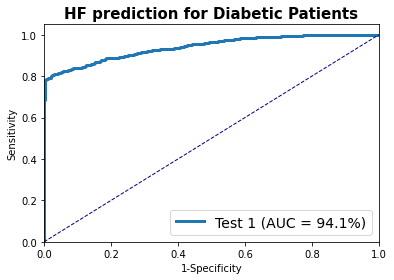

In [ ]:
ut.plot_roc_curve_combined_m("HF prediction for Diabetic Patients",[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())])

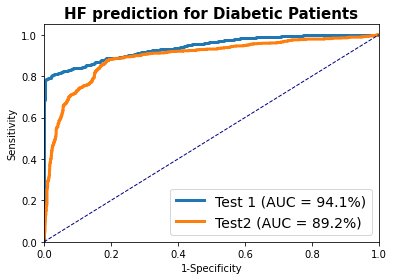

In [ ]:
ut.plot_roc_curve_combined_m("HF prediction for Diabetic Patients",cohorts_preds)

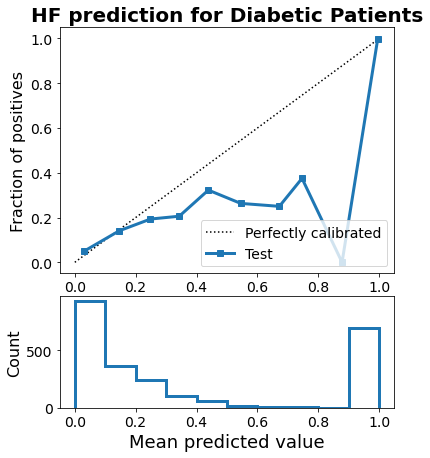

In [ ]:
ut.plot_calibration_curve_m("HF prediction for Diabetic Patients",1,[('Test', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())],n_bins=10)

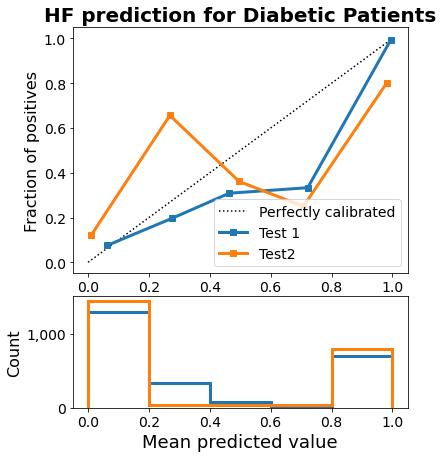

In [ ]:
ut.plot_calibration_curve_m("HF prediction for Diabetic Patients",1,cohorts_preds,n_bins=5)

### Survival Model


In [ ]:
### to load a trained model
best_model_surv = torch.load(output_dir+'ICHI_2023_s1.pth')
if use_cuda:best_model_surv.cuda()

### to get the predictions
t2_labels_s, t2_scores_s = ut.get_preds( test2_mbs , best_model_surv , surv=True )


In [ ]:
#reload(ut)
df_ts2_pred=ut.convert_preds_df(t2_labels_s, t2_scores_s,surv=True)
df_ts2_pred

,Label,TTE,pred_nloghHF
0,0.0,16416.0,0.869195
1,0.0,4746.0,-0.823318
2,0.0,1925.0,0.590466
3,1.0,3073.0,0.271027
4,0.0,6407.0,-0.056884
...,...,...,...
2340,1.0,14181.0,0.334098
2341,1.0,22945.0,-1.274813
2342,0.0,1856.0,-0.016239
2343,1.0,14170.0,0.735186


In [ ]:
vlabels_s, vscores_s = ut.get_preds( valid_mbs , best_model_surv , surv=True )
valid_ref= ut.create_ref_percentile(vlabels_s, vscores_s )
valid_ref

,percentile,pred_nloghHF
0,0.00,-1.38
1,0.01,-0.87
2,0.02,-0.65
3,0.03,-0.54
4,0.04,-0.42
...,...,...
96,0.96,2.94
97,0.97,3.00
98,0.98,3.21
99,0.99,3.61


In [ ]:
df_ts2_pred_perc=ut.assign_perc_based_on_reference(df_ts2_pred,valid_ref)
df_ts2_pred_perc

,Label,TTE,pred_nloghHF,percentile_from_ref,pred_max
0,0.0,16416.0,0.869195,0.27,0.87
1,0.0,4746.0,-0.823318,0.02,-0.65
2,0.0,1925.0,0.590466,0.22,0.62
3,1.0,3073.0,0.271027,0.15,0.32
4,0.0,6407.0,-0.056884,0.11,-0.00
...,...,...,...,...,...
2340,1.0,14181.0,0.334098,0.16,0.36
2341,1.0,22945.0,-1.274813,0.01,-0.87
2342,0.0,1856.0,-0.016239,0.11,-0.00
2343,1.0,14170.0,0.735186,0.25,0.76


In [ ]:
### We can do the following:
df_vs_pred = ut.get_preds_asdf( valid_mbs , best_model_surv , surv=True )
df_vs_pred['cohort']='valid'
df_ts_pred = ut.get_preds_asdf( test_mbs , best_model_surv , surv=True )
df_ts_pred['cohort']='test'
df_ts2_pred['cohort']='test2'
df_s_pred= pd.concat([df_ts_pred,df_vs_pred,df_ts2_pred])
df_s_pred_perc=ut.assign_perc_based_on_reference(df_s_pred,valid_ref)

#### and plot curves as shown later

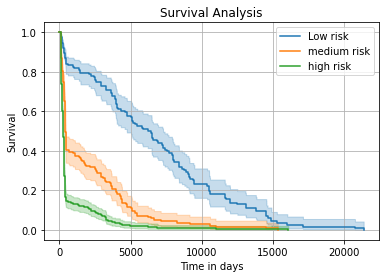

          removed  observed  censored  entrance  at_risk  survival prob
event_at                                                               
113.0           3         2         1         0      570       0.862478
114.0           6         5         1         0      567       0.854873
125.0           4         3         1         0      502       0.804917
183.0           3         2         1         0      354       0.679575
186.0           2         2         0         0      347       0.669884
196.0           3         2         1         0      336       0.650416
197.0           2         2         0         0      333       0.646509
212.0           3         1         2         0      317       0.626815
239.0           2         2         0         0      279       0.577924
267.0           1         1         0         0      250       0.531418
272.0           2         2         0         0      245       0.522829
305.0           1         0         1         0      204       0

In [ ]:
## Model initiation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
subcohort=df_s_pred_perc[df_s_pred_perc['cohort']=='test']
for per_range in [['Low risk',0,0.3],['medium risk',0.3,0.6],['high risk',0.6,1]]:
    [subset,from_p,to_p]=per_range
    sub_per=subcohort[subcohort['percentile_from_ref'].between(from_p,to_p,inclusive='left')]
    t = sub_per['TTE']
    l = sub_per['Label']
    kmf.fit(t,l, label=subset)
    kmf.plot(title='Survival Analysis', ax=ax)#, at_risk_counts =True)
    plt.ylabel('Survival')
    plt.xlabel('Time in days')
    plt.grid(True)
plt.show()

table = kmf.event_table
table['survival prob'] = kmf.survival_function_
print(table.sample(n=20).sort_values(by='event_at'))

In [ ]:
#### calculate clinically relevant metrics
cohorts_preds_surv=[]
for cohort in df_s_pred_perc['cohort'].unique():
    subset_surv_pred=df_s_pred_perc[df_s_pred_perc['cohort']== cohort]
    for t in [365,730,1096,2200]:
        true_label=((subset_surv_pred['Label']==1)&(subset_surv_pred['TTE']<=t)).astype(float)
        cohorts_preds_surv.append([cohort+'_t'+str(t),true_label,subset_surv_pred['percentile_from_ref']])

df_metrics_surv = ut.cl_metrics_m(cohorts_preds_surv,bth=0.15)
df_metrics_surv[['dataset', 'day_window']]= df_metrics_surv['Cohort'].str.split('_t', expand=True)
df_metrics_surv['day_window']=df_metrics_surv['day_window'].astype(int)
df_metrics_surv

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity,dataset,day_window
0,test_t365,0.15,0.763341,0.468015,0.24,0.950000,0.294086,0.373917,0.273999,0.979310,0.428194,0.183397,test,365
1,test_t730,0.15,0.747692,0.496377,0.24,0.950437,0.309154,0.416839,0.324650,0.981050,0.487858,0.194013,test,730
2,test_t1096,0.15,0.747772,0.501218,0.23,0.956772,0.295547,0.420140,0.328509,0.981268,0.492230,0.194910,test,1096
3,test_t2200,0.15,0.742971,0.506152,0.23,0.952580,0.297186,0.428807,0.339122,0.980474,0.503943,0.196952,test,2200
4,valid_t365,0.15,0.772408,0.491247,0.24,0.953020,0.295728,0.379026,0.281310,0.979866,0.437126,0.182913,valid,365
5,valid_t730,0.15,0.759650,0.534345,0.20,0.951705,0.256112,0.421965,0.332370,0.980114,0.496403,0.193248,valid,730
6,valid_t1096,0.15,0.760231,0.538752,0.20,0.952247,0.257310,0.425268,0.336224,0.980337,0.500717,0.194152,valid,1096
7,valid_t2200,0.15,0.757715,0.544018,0.20,0.953804,0.260973,0.435178,0.347784,0.980978,0.513514,0.196916,valid,2200
8,test2_t365,0.15,0.976633,0.024090,0.50,1.000000,0.970977,0.699787,0.002833,1.000000,0.005650,0.699531,test2,365
9,test2_t730,0.15,0.838932,0.018709,0.08,1.000000,0.494017,0.700213,0.005666,0.800000,0.011252,0.700000,test2,730


dataset
test     AxesSubplot(0.125,0.125;0.775x0.755)
test2    AxesSubplot(0.125,0.125;0.775x0.755)
valid    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

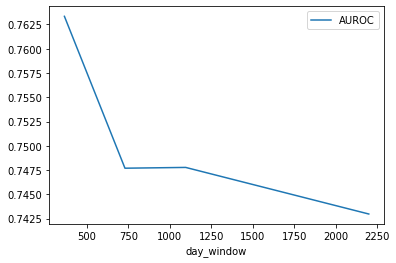

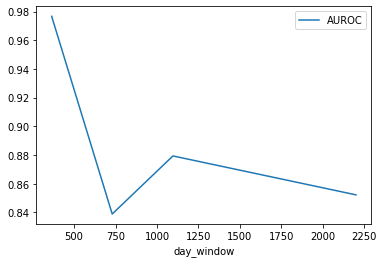

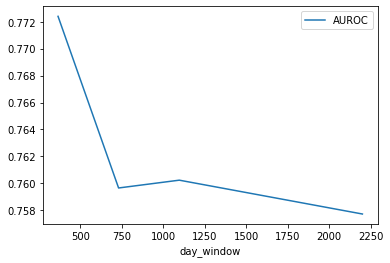

In [ ]:
df_metrics_surv.groupby('dataset')[['day_window','AUROC']].plot(x='day_window')

## Compare with Logestic Regression as Baseline

In [ ]:
mlb = MultiLabelBinarizer(classes=range(input_size_l[0])[1:])
def ml_preprocess(data_sl):
    labels_d=[]
    features_d=[]

    for pt in data_sl:
        labels_d.append(pt[1])
        x=[]
        for v in pt[-1]:
            x.extend(v[-1])
        features_d.append(x)
    nfeatures_d= mlb.fit_transform(features_d)
    return nfeatures_d, labels_d

nfeatures_tr, labels_tr = ml_preprocess(train_sl)
nfeatures_t, labels_t = ml_preprocess(test_sl)
nfeatures_v, labels_v = ml_preprocess(valid_sl)
nfeatures_t2, labels_t2 = ml_preprocess(test_sl2)


In [ ]:
HFlabels_tr= np.array(labels_tr)[:,0]
HFlabels_t= np.array(labels_t)[:,0]
HFlabels_v= np.array(labels_v)[:,0]
HFlabels_t2= np.array(labels_t2)[:,0]


In [ ]:
EHR_LR= lm.LogisticRegression()
EHR_LR.fit(nfeatures_tr, HFlabels_tr)

LogisticRegression()

In [ ]:
LR_labels,LR_scores,LR_auc_p,LR_ap_score,LR_tn, LR_fp, LR_fn, LR_tp,LR_class_rep_dic=ut.ml_evaluate(EHR_LR,nfeatures_t, HFlabels_t)
LR_auc_p,LR_ap_score,LR_tn, LR_fp, LR_fn, LR_tp,LR_class_rep_dic

Model Performance
AUC = 95.18%.
Confusion Matrix tn, fp, fn, tp: 1502 32 177 712
Classification Report : {'0.0': {'precision': 0.8945801072066706, 'recall': 0.9791395045632334, 'f1-score': 0.9349517584811702, 'support': 1534}, '1.0': {'precision': 0.956989247311828, 'recall': 0.8008998875140607, 'f1-score': 0.8720146968769137, 'support': 889}, 'accuracy': 0.913743293437887, 'macro avg': {'precision': 0.9257846772592493, 'recall': 0.8900196960386471, 'f1-score': 0.9034832276790419, 'support': 2423}, 'weighted avg': {'precision': 0.9174780541953147, 'recall': 0.913743293437887, 'f1-score': 0.9118601168112636, 'support': 2423}}


(0.9517769698605145,
 0.9443328125713646,
 1502,
 32,
 177,
 712,
 {'0.0': {'f1-score': 0.9349517584811702,
   'precision': 0.8945801072066706,
   'recall': 0.9791395045632334,
   'support': 1534},
  '1.0': {'f1-score': 0.8720146968769137,
   'precision': 0.956989247311828,
   'recall': 0.8008998875140607,
   'support': 889},
  'accuracy': 0.913743293437887,
  'macro avg': {'f1-score': 0.9034832276790419,
   'precision': 0.9257846772592493,
   'recall': 0.8900196960386471,
   'support': 2423},
  'weighted avg': {'f1-score': 0.9118601168112636,
   'precision': 0.9174780541953147,
   'recall': 0.913743293437887,
   'support': 2423}})

In [ ]:
LR_labels,LR_scores,LR_auc_p,LR_ap_score,LR_tn, LR_fp, LR_fn, LR_tp,LR_class_rep_dic=ut.ml_evaluate(EHR_LR,nfeatures_t2, HFlabels_t2)
LR_auc_p,LR_ap_score,LR_tn, LR_fp, LR_fn, LR_tp,LR_class_rep_dic

Model Performance
AUC = 84.24%.
Confusion Matrix tn, fp, fn, tp: 1261 232 174 678
Classification Report : {'0.0': {'precision': 0.8787456445993032, 'recall': 0.8446081714668453, 'f1-score': 0.8613387978142077, 'support': 1493}, '1.0': {'precision': 0.7450549450549451, 'recall': 0.795774647887324, 'f1-score': 0.7695800227014756, 'support': 852}, 'accuracy': 0.826865671641791, 'macro avg': {'precision': 0.8119002948271241, 'recall': 0.8201914096770846, 'f1-score': 0.8154594102578416, 'support': 2345}, 'weighted avg': {'precision': 0.8301723072808413, 'recall': 0.826865671641791, 'f1-score': 0.8280004283489422, 'support': 2345}}


(0.8424046174793796,
 0.7817010613696229,
 1261,
 232,
 174,
 678,
 {'0.0': {'f1-score': 0.8613387978142077,
   'precision': 0.8787456445993032,
   'recall': 0.8446081714668453,
   'support': 1493},
  '1.0': {'f1-score': 0.7695800227014756,
   'precision': 0.7450549450549451,
   'recall': 0.795774647887324,
   'support': 852},
  'accuracy': 0.826865671641791,
  'macro avg': {'f1-score': 0.8154594102578416,
   'precision': 0.8119002948271241,
   'recall': 0.8201914096770846,
   'support': 2345},
  'weighted avg': {'f1-score': 0.8280004283489422,
   'precision': 0.8301723072808413,
   'recall': 0.826865671641791,
   'support': 2345}})